# DMIA sport intro: How frequent is this password?

https://www.kaggle.com/c/dmia-sport-2019-fall-intro/overview

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

import math
import sys
import os

In [2]:
sys.path.append("..")

### 1. Data preparation  

In [3]:
directory = '../data/raw'
if not os.path.exists(directory):
    os.makedirs(directory)

copy data to "../data/raw/" from

https://www.kaggle.com/c/dmia-sport-2019-fall-intro/data

In [4]:
train_data = pd.read_csv('../data/raw/train.csv.zip', compression='zip')
test_data = pd.read_csv('../data/raw/Xtest.csv.zip', compression='zip')
print(train_data.shape)
print(test_data.shape)

(4151496, 2)
(1037875, 2)


#### 1.1 Train

In [5]:
train_data.dropna(inplace=True)

In [6]:
#train data sample
train_data.sort_values(by='Times', ascending=False).head()

,Password,Times
2715397,123456,55893
3136279,qwerty,13137
1175081,123456789,11696
2363307,12345,10938
2988373,1234,6432


In [7]:
N_train_recs = train_data.shape[0]
train_data.shape

(4151494, 2)

#### 1.2 Test

In [8]:
# test data sample
test_data.head()

,Id,Password
0,0,ThaisCunha
1,1,697775113
2,2,922a16922a
3,3,andy74
4,4,joemack


In [9]:
test_data.shape

(1037875, 2)

In [10]:
y = train_data.Times
train_data.drop(columns='Times', inplace=True)
test_data.drop(columns='Id', inplace=True)

#### 1.3 Train + Test -> data

In [11]:
data = train_data.append(test_data)
data.shape

(5189369, 1)

In [12]:
#максимальная длина пароля - дальше понадобится
data['len'] = data.Password.apply(lambda x: len(str(x)))
max_pass_len = data['len'].max()
max_pass_len

42

####  1.4 Separtate symbols for tokeniztion

In [13]:
data['Password'] = data.Password.apply(lambda x: ' '.join(re.findall('\S', str(x))))  

In [14]:
data.head()

,Password,len
0,6 3 1 X n i V x 2 l S 5 I,13
1,L E G I T 7 4 7,8
2,7 4 2 3 6 4 e s,8
3,3 8 4 6 6 9 6 4 7 7,10
4,l a u r a h o p,8


In [15]:
def list_merge(lstlst):
    all=[]
    for lst in lstlst:
          all.extend(lst)
    return all

chars = data.Password.apply(lambda x: str(x).split(' ')).values
chars_dict = set(list_merge(chars))
dict_len = len(chars_dict)
print(dict_len)

97


### 2. LSTM model

In [16]:
from keras.models import Sequential
from keras.layers import Dense,  Activation, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

#### 2.1 Tokenization

In [17]:
%%time

tokenizer = Tokenizer(dict_len, filters='', lower=False)
tokenizer.fit_on_texts(data['Password'])
data_tokens = tokenizer.texts_to_sequences(data['Password'])

CPU times: user 1min 9s, sys: 1.35 s, total: 1min 11s
Wall time: 1min 15s


In [18]:
# save tokenizer
with open('../lstm_model/resources/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

before

In [19]:
data.head(3)

,Password,len
0,6 3 1 X n i V x 2 l S 5 I,13
1,L E G I T 7 4 7,8
2,7 4 2 3 6 4 e s,8


after

In [20]:
pd.DataFrame(data_tokens[:3])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,19,12,2,61,9,8,58,35,4.0,15.0,39.0,14.0,52.0
1,43,38,49,52,42,17,18,17,NaN,NaN,NaN,NaN,NaN
2,17,18,4,12,19,18,3,11,NaN,NaN,NaN,NaN,NaN


In [21]:
data_tokenized = pad_sequences(data_tokens, max_pass_len, padding='post')
print(data_tokenized.shape)

(5189369, 42)


In [22]:
pd.DataFrame(data_tokenized[:3])

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,19,12,2,61,9,8,58,35,4,15,...,0,0,0,0,0,0,0,0,0,0
1,43,38,49,52,42,17,18,17,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,18,4,12,19,18,3,11,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.2 Train - validation split 90/10

In [23]:
from sklearn.model_selection import train_test_split

X = data_tokenized[:N_train_recs]      #train part
X_test = data_tokenized[N_train_recs:] #test part


X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.1, 
                                                  train_size=0.9, 
                                                  random_state=87)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape, end='\n\n')

print('X_val:', X_val.shape)
print('y_val:', y_val.shape, end='\n\n')

print('X_test:', X_test.shape)

X_train: (3736344, 42)
y_train: (3736344,)

X_val: (415150, 42)
y_val: (415150,)

X_test: (1037875, 42)


In [24]:
import gc
gc.collect()

20

In [25]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Concatenate, Input, ReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#### 2.3 Custom Loss function RMSLE

In [26]:
from lstm_model.utils import rmsle

#### 2.4 Train 2-layers LSTM model with char embeddings 

In [29]:
%%time

EMBEDDING_VECTOR_LENGHT = 16
HIDDEN_DIM = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

model = Sequential()
model.add(Embedding(dict_len, 
                    EMBEDDING_VECTOR_LENGHT, 
                    input_length= max_pass_len,
                    mask_zero=True,))

model.add(LSTM(HIDDEN_DIM))
model.add(Dense(1))
model.add(ReLU())

opt = Adam()
model.compile(loss=rmsle,
              optimizer=opt)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 42, 16)            1552      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1)                 0         
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 835 ms, sys: 33.9 ms, total: 869 ms
Wall time: 901 ms


In [30]:
%%time

hist = model.fit(
    X_train, y_train, 
    epochs=2, 
    batch_size=512,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping])

Epoch 1/2
7298/7298 [==============================] - 393s 53ms/step - loss: 0.3984 - val_loss: 0.3533
Epoch 2/2
7298/7298 [==============================] - 345s 47ms/step - loss: 0.3505 - val_loss: 0.3464
CPU times: user 24min 25s, sys: 4min 34s, total: 28min 59s
Wall time: 12min 17s


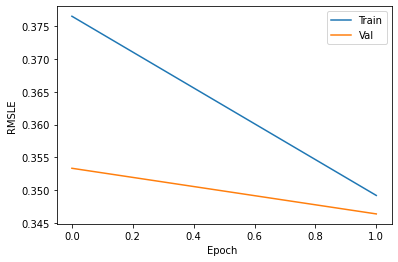

In [31]:
plt.plot(hist.history['loss'], label = 'Train');
plt.plot(hist.history['val_loss'], label ='Val');
plt.legend();
plt.xlabel('Epoch ');
plt.ylabel('RMSLE');

##### safe model

In [34]:
model.save('../lstm_model/resources/lstm_16emb_16d_model') 

INFO:tensorflow:Assets written to: ../lstm_model/resources/lstm_16emb_16d_model/assets


INFO:tensorflow:Assets written to: ../lstm_model/resources/lstm_16emb_16d_model/assets


##### load model

In [35]:
from keras.models import load_model
model = load_model('../lstm_model/resources/lstm_16emb_16d_model', custom_objects={'rmsle':rmsle})

### 3. Embeddings visualization

In [36]:
from sklearn.manifold import TSNE
from matplotlib import pylab

In [37]:
embeddings = model.layers[0].get_weights()[0]

In [38]:
embeddings.shape

(97, 16)

In [39]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=30000)
two_d_embeddings = tsne.fit_transform(embeddings)

In [40]:
two_d_embeddings.shape

(97, 2)

In [41]:
word_index = tokenizer.word_index

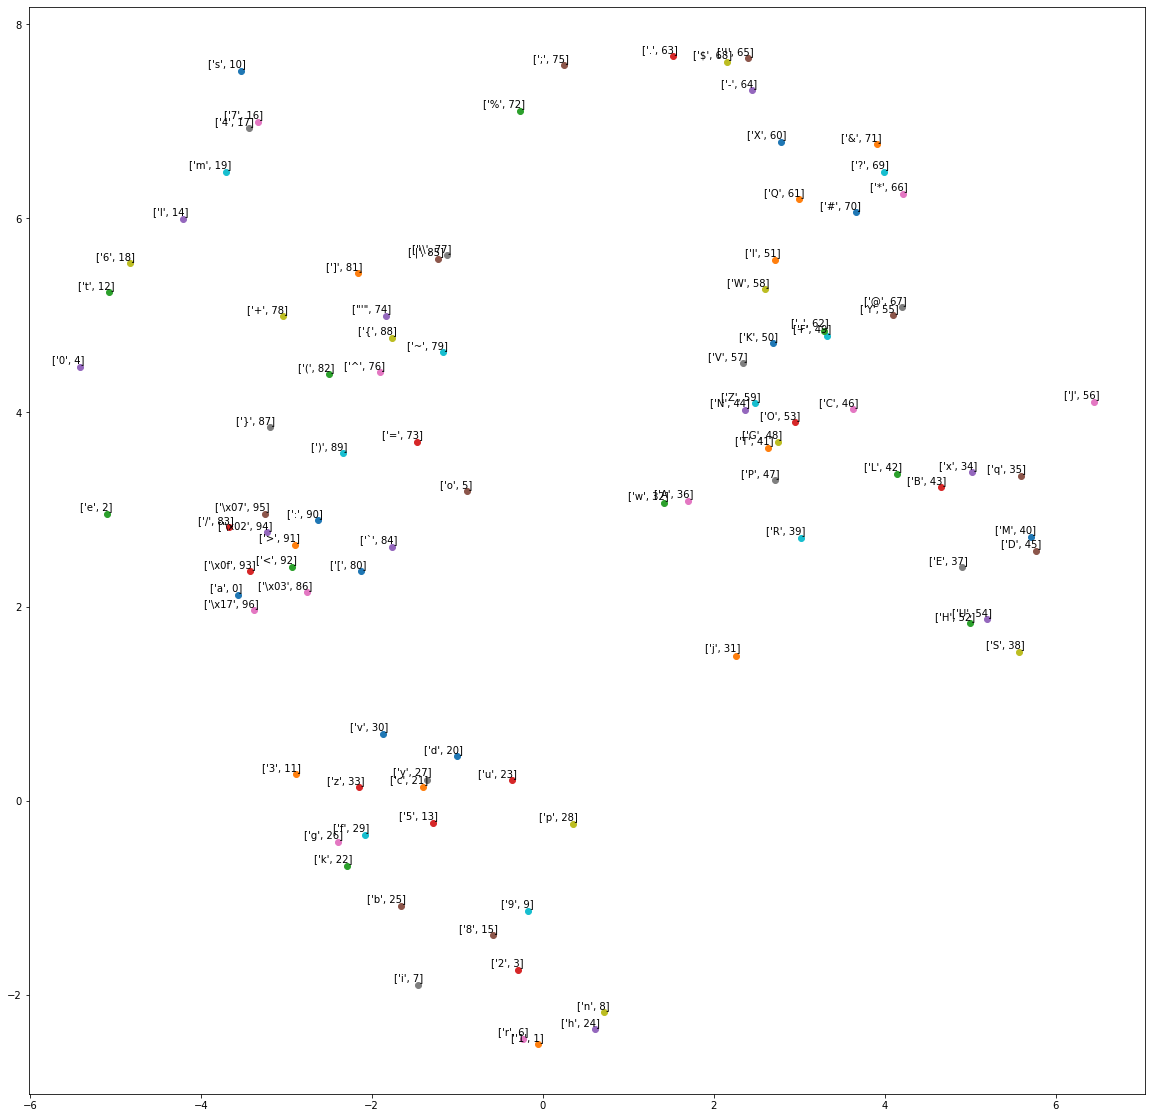

In [42]:
pylab.figure(figsize=(20,20))
for i, emb in zip(range(dict_len), two_d_embeddings):
    label = labels = list(word_index.keys())[i]
    x,y = emb   
    pylab.scatter(x, y)
    pylab.annotate([label,i], xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
pylab.show()

### 4. Predict for test part

In [43]:
%%time

y_pred = model.predict(X_test, batch_size=1024)

CPU times: user 45.8 s, sys: 16.1 s, total: 1min 1s
Wall time: 32 s


In [ ]:
submission = pd.read_csv('../data/raw/sample_submission.csv.zip', index_col='Id', compression='zip');
submission.Times = y_pred;

In [46]:
submission.to_csv('../data/processed/res_2.csv')